# Partie 3 : Analyse et comparaison des embeddings textuels

In [ ]:
import pandas as pd

df = pd.read_parquet("hf://datasets/DBQ/Chanel.Product.prices.Germany/data/train-00000-of-00001-d681c47b79d4401f.parquet")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
import re

def clean_title(title):
    try:
        title = title.strip()  # Supprimer les espaces en début et fin
        title = re.sub(r'\s+', ' ', title)  # Remplacer les espaces multiples par un espace simple
        title = re.sub(r'[^\w\s]', '', title)  # Supprimer les caractères spéciaux
        title = title.lower()  # Mettre en minuscule
        return title
    except Exception as e:
        print(f"Error cleaning title: {title} - Error: {e}")
        return title

In [ ]:
df['title_cleaned'] = df['title'].apply(clean_title)

## 1. Traduction des descriptions (anglais)

In [ ]:
!pip install transformers sentencepiece

import pandas as pd
import re
from transformers import pipeline

# Load the pre-trained German-to-English translation model
translator = pipeline("translation_de_to_en", model="Helsinki-NLP/opus-mt-de-en")

def translate_title(title):
    try:
        translated_title = translator(title, max_length=512)[0]['translation_text'] # Limit max_length for long titles
        return translated_title
    except Exception as e:
        print(f"Error translating title: {title} - Error: {e}")
        return title


df['title_translated'] = df['title_cleaned'].apply(translate_title)

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/298M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/797k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/768k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [ ]:
print(df[['title', 'title_translated']].head())

                                               title  \
0  Tweed & goldfarbenes Metall  Schwarz  Rosa & B...   
1                                               n.a.   
2                                            Schwarz   
3           Silberfarben. Gläser: Braun  Mit Verlauf   
4             Blau & Rosa. Gläser: Grau  Mit Verlauf   

                               title_translated  
0  tweet gold colored metal black pink bordeaux  
1                                            na  
2                                         Black  
3      silver colored glasses brown with course  
4          blue pink glasses grey with gradient  


## 2. Génération des embeddings textuels

### o Utiliser des modèles NLP pré-entraînés comme BERT et Sentence-BERT pour extraire les embeddings des descriptions en explorant différentes options comme la moyenne des tokens ou l’utilisation directe de la sortie CLS.

#### o BERT

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def generate_embeddings(text, method="cls"):
    if not isinstance(text, str) or text.strip() == "":
        return [0] * model.config.hidden_size

    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)

    if method == "cls":
        return outputs.last_hidden_state[:, 0, :].squeeze().tolist()
    elif method == "mean":
        return outputs.last_hidden_state.mean(dim=1).squeeze().tolist()
    elif method == "cls_mean":
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze()
        mean_embedding = outputs.last_hidden_state.mean(dim=1).squeeze()
        return torch.cat((cls_embedding, mean_embedding)).tolist()
    else:
        raise ValueError("Invalid method. Choose from 'cls', 'mean', or 'cls_mean'.")


df['embeddings_cls'] = df['title_translated'].apply(lambda x: generate_embeddings(x, method="cls"))
df['embeddings_mean'] = df['title_translated'].apply(lambda x: generate_embeddings(x, method="mean"))
df['embeddings_cls_mean'] = df['title_translated'].apply(lambda x: generate_embeddings(x, method="cls_mean"))

df.to_parquet("textual_embeddings_bert.parquet")
print("Embeddings générés et sauvegardés.")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Embeddings générés et sauvegardés.


#### o Sentence-BERT

In [ ]:
from sentence_transformers import SentenceTransformer
import pandas as pd

# Charger Sentence-BERT
model = SentenceTransformer('all-MiniLM-L6-v2')  # Changez pour un autre modèle Sentence-BERT si nécessaire

# Générer les embeddings
df['embeddings_sentence_bert'] = df['title_translated'].apply(lambda x: model.encode(str(x)) if pd.notnull(x) else [0]*384)

# Sauvegarder les résultats
df.to_parquet("textual_embeddings_sentence_bert.parquet")
print("Embeddings générés et sauvegardés.")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embeddings générés et sauvegardés.


## 3. Analyse des embeddings

### o Calculer les distances entre les embeddings des descriptions pour des exemples parlants (par exemple, des produits très similaires ou totalement différents).

#### BERT

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

embeddings_bert = np.stack(df['embeddings_cls'])

# Calcul des similarités cosinus
cosine_sim_matrix = cosine_similarity(embeddings_bert)

# Conversion en DataFrame pour une visualisation claire
similarity_df_bert = pd.DataFrame(
    cosine_sim_matrix,
    index=df['title_translated'],
    columns=df['title_translated']
)

# Sauvegarder ou afficher la matrice
similarity_df_bert.to_csv("cosine_similarity_matrix_bert.csv")
print("Matrice de similarité cosinus générée pour le model BERT.")

Matrice de similarité cosinus générée pour le model BERT.


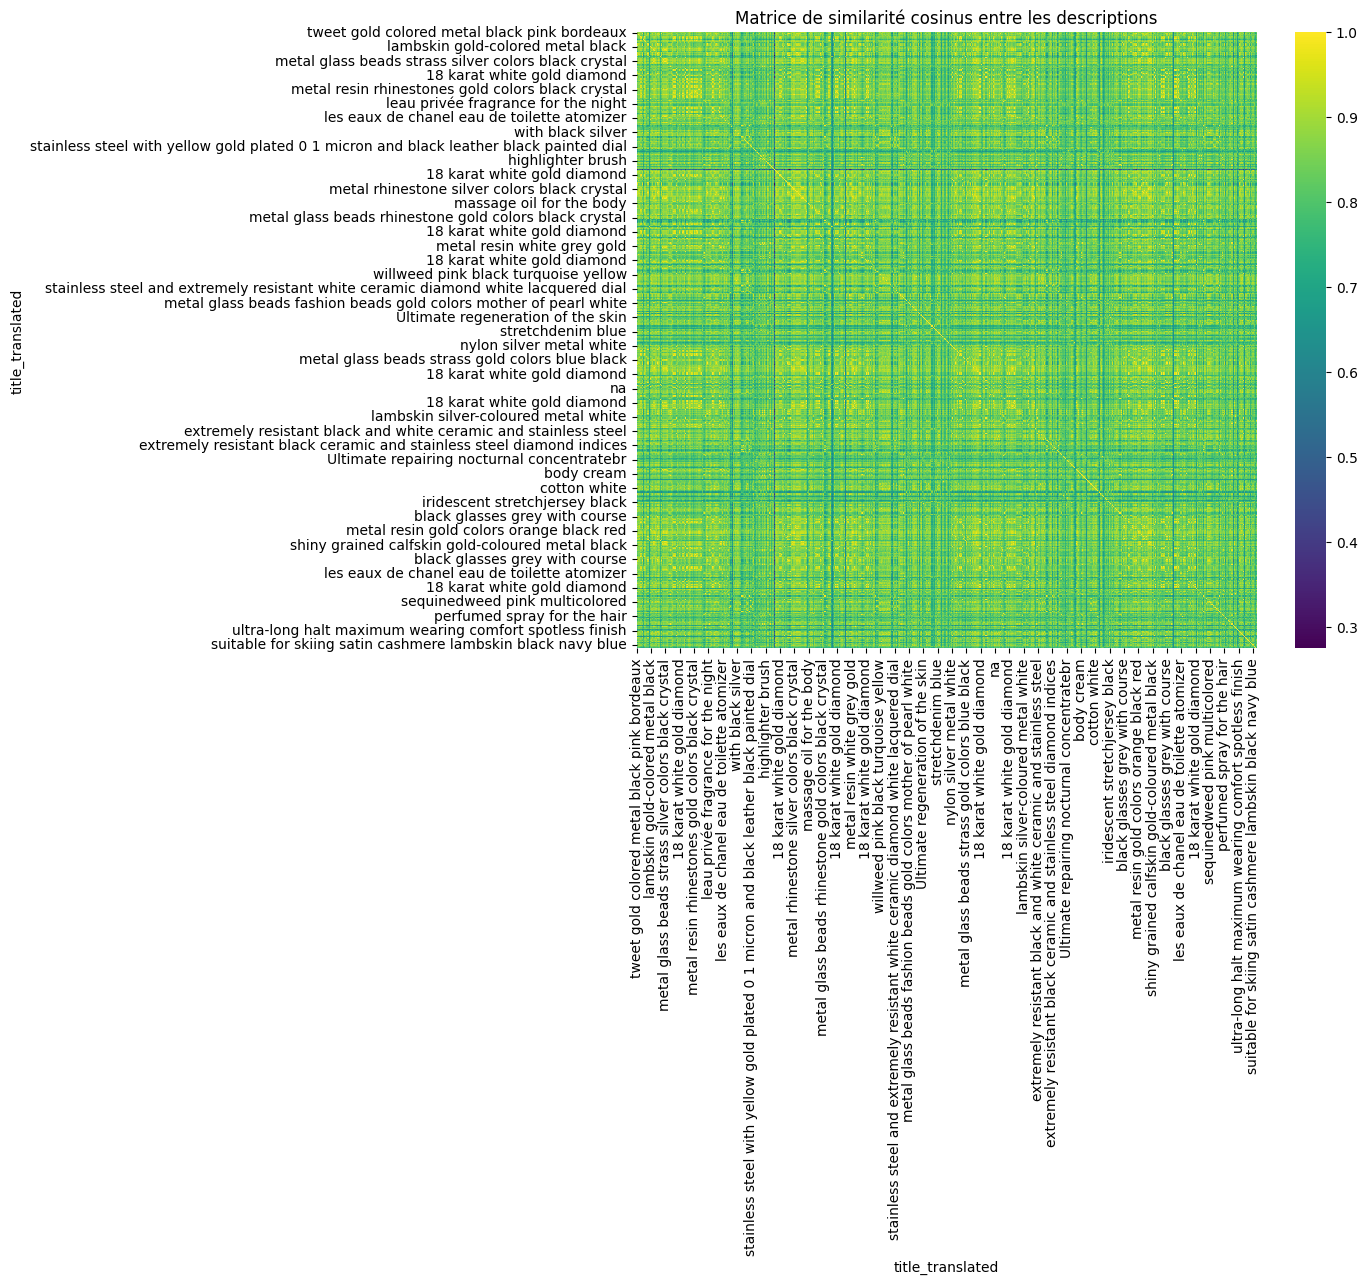

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_df_bert, cmap="viridis", annot=False)
plt.title("Matrice de similarité cosinus entre les descriptions")
plt.show()

#### Sentence-BERT

In [ ]:
embeddings_sentence_bert = np.stack(df['embeddings_sentence_bert'])

# Calcul des similarités cosinus
cosine_sim_matrix = cosine_similarity(embeddings_sentence_bert)

# Conversion en DataFrame pour une visualisation claire
similarity_df_sentence_bert = pd.DataFrame(
    cosine_sim_matrix,
    index=df['title_translated'],
    columns=df['title_translated']
)

# Sauvegarder ou afficher la matrice
similarity_df_sentence_bert.to_csv("cosine_similarity_matrix_sentence_bert.csv")
print("Matrice de similarité cosinus générée pour le model Sentence-BERT.")

Matrice de similarité cosinus générée pour le model Sentence-BERT.


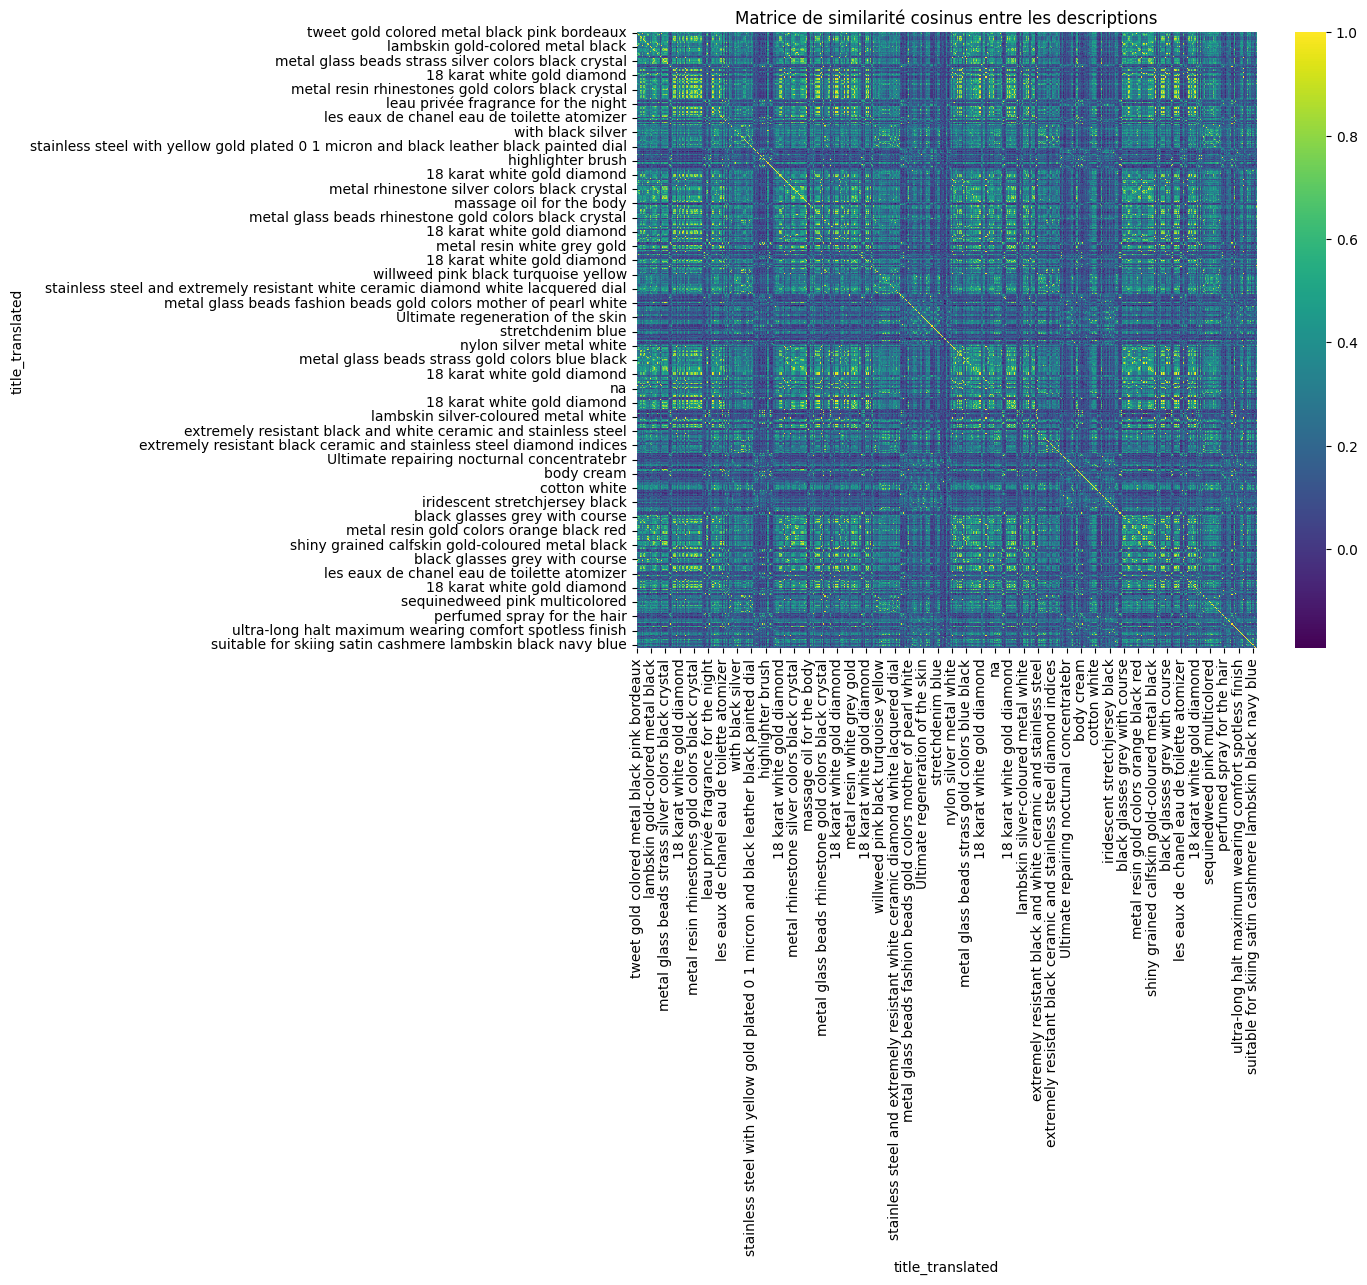

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_df_sentence_bert, cmap="viridis", annot=False)
plt.title("Matrice de similarité cosinus entre les descriptions")
plt.show()

## 4. Visualisation

### Réduction dimensionnelle et visualisation des embeddings textuels pour détecter des clusters potentiels.

#### BERT

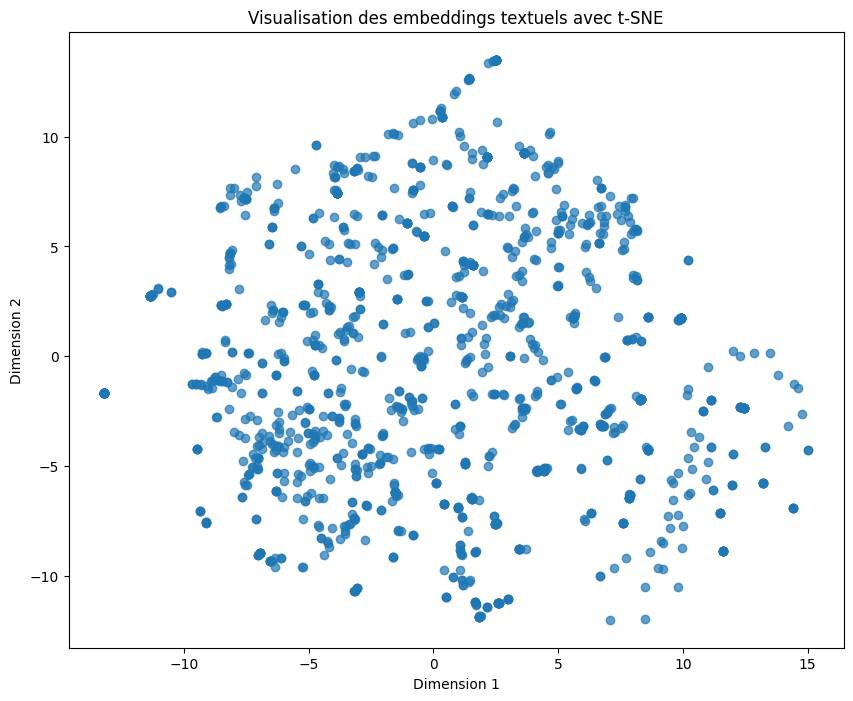

In [ ]:
from sklearn.manifold import TSNE

# Réduction dimensionnelle avec t-SNE
tsne_bert = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=300)
embeddings_2d_tsne_bert = tsne_bert.fit_transform(np.stack(df['embeddings_cls']))

# Visualisation des clusters potentiels
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d_tsne_bert[:, 0], embeddings_2d_tsne_bert[:, 1], alpha=0.7)
plt.title("Visualisation des embeddings textuels avec t-SNE")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

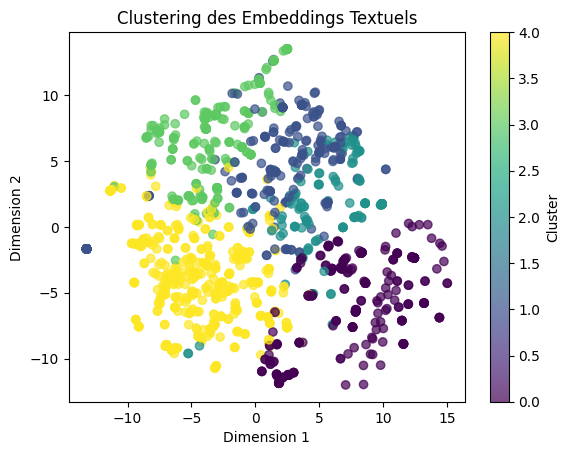

In [ ]:
from sklearn.cluster import KMeans

# Appliquer K-Means
n_clusters = 5
kmeans_bert = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster_bert'] = kmeans_bert.fit_predict(embeddings_bert)

# Visualisation avec les clusters
plt.scatter(embeddings_2d_tsne_bert[:, 0], embeddings_2d_tsne_bert[:, 1], c=df['cluster_bert'], cmap='viridis', alpha=0.7)
plt.title("Clustering des Embeddings Textuels")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(label="Cluster")
plt.show()

#### Sentence-BERT

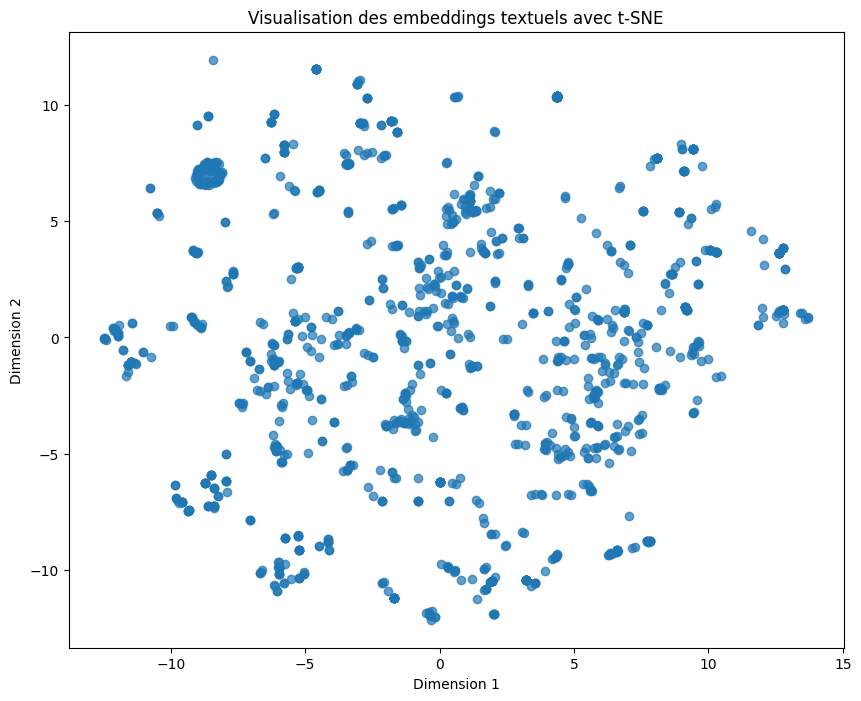

In [ ]:
from sklearn.manifold import TSNE

# Réduction dimensionnelle avec t-SNE
tsne_sentence_bert = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=300)
embeddings_2d_tsne_sentence_bert = tsne_sentence_bert.fit_transform(np.stack(df['embeddings_sentence_bert']))

# Visualisation des clusters potentiels
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d_tsne_sentence_bert[:, 0], embeddings_2d_tsne_sentence_bert[:, 1], alpha=0.7)
plt.title("Visualisation des embeddings textuels avec t-SNE")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

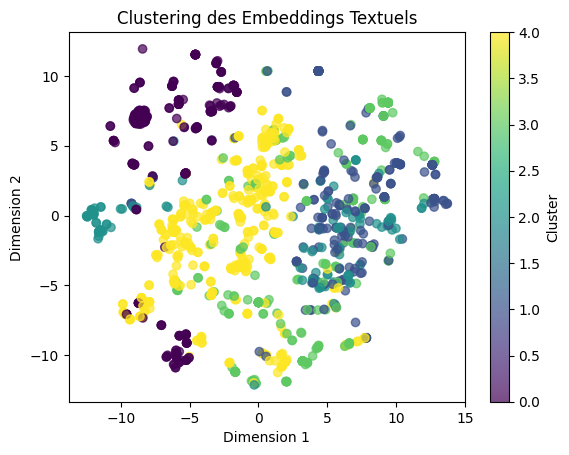

In [ ]:
from sklearn.cluster import KMeans

# Appliquer K-Means
n_clusters = 5
kmeans_sentence_bert = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster_sentence_bert'] = kmeans_sentence_bert.fit_predict(embeddings_bert)

# Visualisation avec les clusters
plt.scatter(embeddings_2d_tsne_sentence_bert[:, 0], embeddings_2d_tsne_sentence_bert[:, 1], c=df['cluster_bert'], cmap='viridis', alpha=0.7)
plt.title("Clustering des Embeddings Textuels")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(label="Cluster")
plt.show()